# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## 1. Import the Custom Trading Env

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## 2. Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]})
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.iloc[0]['close0']

0.000590391961223056

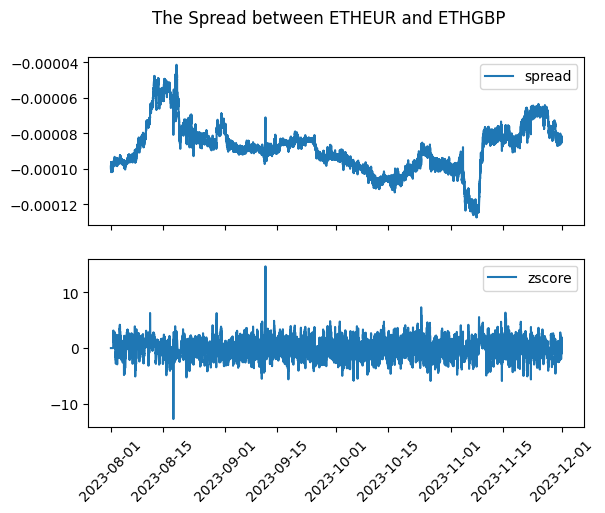

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = (len(train)-best_params['period']) * 0.9
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## 3. Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## 4. Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=1, gamma=1, batch_size=256)
model_ppo.learn(total_timesteps=max_train_len-50, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

-----------------------------
| time/              |      |
|    fps             | 302  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 313         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011508092 |
|    clip_fraction        | 0.0802      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0703     |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 34.5        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 321         |
|    iterations           | 3           |
|    time_elapsed         | 19          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.010739582 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.31        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 41.3        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 322         |
|    iterations           | 4           |
|    time_elapsed         | 25          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012953397 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.0963      |
|    learning_rate        | 0.0003      |
|    loss                 | 15.9        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 54.9        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 5           |
|    time_elapsed         | 31          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.015069627 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.969      |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.5        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 71.1        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 325        |
|    iterations           | 6          |
|    time_elapsed         | 37         |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.02088014 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.83      |
|    explained_variance   | 0.135      |
|    learning_rate        | 0.0003     |
|    loss                 | 46.9       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.0215    |
|    value_loss           | 120        |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 326         |
|    iterations           | 7           |
|    time_elapsed         | 43          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.010097512 |
|    clip_fraction        | 0.0635      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.764      |
|    explained_variance   | 0.1         |
|    learning_rate        | 0.0003      |
|    loss                 | 54.8        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 132         |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 329          |
|    iterations           | 8            |
|    time_elapsed         | 49           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0052121044 |
|    clip_fraction        | 0.0434       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0.0565       |
|    learning_rate        | 0.0003       |
|    loss                 | 92.6         |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.0114      |
|    value_loss           | 210          |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 331         |
|    iterations           | 9           |
|    time_elapsed         | 55          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.005098243 |
|    clip_fraction        | 0.0425      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.446      |
|    explained_variance   | 0.00989     |
|    learning_rate        | 0.0003      |
|    loss                 | 114         |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00951    |
|    value_loss           | 254         |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 334         |
|    iterations           | 10          |
|    time_elapsed         | 61          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.012363449 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.472      |
|    explained_variance   | 0.0422      |
|    learning_rate        | 0.0003      |
|    loss                 | 96.3        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 215         |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 336         |
|    iterations           | 11          |
|    time_elapsed         | 66          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.002962091 |
|    clip_fraction        | 0.0303      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.366      |
|    explained_variance   | 0.016       |
|    learning_rate        | 0.0003      |
|    loss                 | 126         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00671    |
|    value_loss           | 279         |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 337          |
|    iterations           | 12           |
|    time_elapsed         | 72           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0046691718 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.347       |
|    explained_variance   | -0.0207      |
|    learning_rate        | 0.0003       |
|    loss                 | 121          |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00896     |
|    value_loss           | 268          |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 338          |
|    iterations           | 13           |
|    time_elapsed         | 78           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0024663294 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.278       |
|    explained_variance   | -0.0268      |
|    learning_rate        | 0.0003       |
|    loss                 | 126          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00539     |
|    value_loss           | 285          |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 340          |
|    iterations           | 14           |
|    time_elapsed         | 84           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0017000858 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.00428      |
|    learning_rate        | 0.0003       |
|    loss                 | 141          |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00488     |
|    value_loss           | 314          |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 342         |
|    iterations           | 15          |
|    time_elapsed         | 89          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.001339459 |
|    clip_fraction        | 0.0103      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 0.00172     |
|    learning_rate        | 0.0003      |
|    loss                 | 144         |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00444    |
|    value_loss           | 313         |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 340          |
|    iterations           | 16           |
|    time_elapsed         | 96           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0011488039 |
|    clip_fraction        | 0.00884      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.195       |
|    explained_variance   | 0.0053       |
|    learning_rate        | 0.0003       |
|    loss                 | 146          |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00337     |
|    value_loss           | 318          |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 341          |
|    iterations           | 17           |
|    time_elapsed         | 101          |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0014825258 |
|    clip_fraction        | 0.0107       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.162       |
|    explained_variance   | 0.00348      |
|    learning_rate        | 0.0003       |
|    loss                 | 145          |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00375     |
|    value_loss           | 318          |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 343          |
|    iterations           | 18           |
|    time_elapsed         | 107          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0009951987 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 0.00318      |
|    learning_rate        | 0.0003       |
|    loss                 | 143          |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00329     |
|    value_loss           | 311          |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 344          |
|    iterations           | 19           |
|    time_elapsed         | 112          |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0005661346 |
|    clip_fraction        | 0.00332      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.14        |
|    explained_variance   | 0.00158      |
|    learning_rate        | 0.0003       |
|    loss                 | 152          |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.00205     |
|    value_loss           | 338          |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 346          |
|    iterations           | 20           |
|    time_elapsed         | 118          |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0008977278 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.112       |
|    explained_variance   | 0.0023       |
|    learning_rate        | 0.0003       |
|    loss                 | 149          |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00297     |
|    value_loss           | 324          |
------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 349           |
|    iterations           | 21            |
|    time_elapsed         | 123           |
|    total_timesteps      | 43008         |
| train/                  |               |
|    approx_kl            | 0.00033779888 |
|    clip_fraction        | 0.000537      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.108        |
|    explained_variance   | -0.00794      |
|    learning_rate        | 0.0003        |
|    loss                 | 151           |
|    n_updates            | 200           |
|    policy_gradient_loss | -0.00115      |
|    value_loss           | 328           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 351           |
|    iterations           | 22            |
|    time_elapsed         | 128           |
|    total_timesteps      | 45056         |
| train/                  |               |
|    approx_kl            | 0.00039190365 |
|    clip_fraction        | 0.00293       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0852       |
|    explained_variance   | -0.000712     |
|    learning_rate        | 0.0003        |
|    loss                 | 157           |
|    n_updates            | 210           |
|    policy_gradient_loss | -0.00122      |
|    value_loss           | 337           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 353           |
|    iterations           | 23            |
|    time_elapsed         | 133           |
|    total_timesteps      | 47104         |
| train/                  |               |
|    approx_kl            | 0.00041572363 |
|    clip_fraction        | 0.00293       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0586       |
|    explained_variance   | 3.04e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 158           |
|    n_updates            | 220           |
|    policy_gradient_loss | -0.00142      |
|    value_loss           | 345           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 355           |
|    iterations           | 24            |
|    time_elapsed         | 138           |
|    total_timesteps      | 49152         |
| train/                  |               |
|    approx_kl            | 3.7014164e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0738       |
|    explained_variance   | 0.0027        |
|    learning_rate        | 0.0003        |
|    loss                 | 155           |
|    n_updates            | 230           |
|    policy_gradient_loss | -0.00028      |
|    value_loss           | 337           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 356           |
|    iterations           | 25            |
|    time_elapsed         | 143           |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | 0.00014277536 |
|    clip_fraction        | 0.00151       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0816       |
|    explained_variance   | 0.00157       |
|    learning_rate        | 0.0003        |
|    loss                 | 146           |
|    n_updates            | 240           |
|    policy_gradient_loss | -0.000629     |
|    value_loss           | 320           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 357           |
|    iterations           | 26            |
|    time_elapsed         | 149           |
|    total_timesteps      | 53248         |
| train/                  |               |
|    approx_kl            | 0.00036866544 |
|    clip_fraction        | 0.00391       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0825       |
|    explained_variance   | 0.00215       |
|    learning_rate        | 0.0003        |
|    loss                 | 149           |
|    n_updates            | 250           |
|    policy_gradient_loss | -0.00163      |
|    value_loss           | 327           |
-------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 358          |
|    iterations           | 27           |
|    time_elapsed         | 154          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0006094368 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0974      |
|    explained_variance   | 0.00102      |
|    learning_rate        | 0.0003       |
|    loss                 | 156          |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00168     |
|    value_loss           | 339          |
------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 359           |
|    iterations           | 28            |
|    time_elapsed         | 159           |
|    total_timesteps      | 57344         |
| train/                  |               |
|    approx_kl            | 0.00023004919 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0935       |
|    explained_variance   | 0.000815      |
|    learning_rate        | 0.0003        |
|    loss                 | 143           |
|    n_updates            | 270           |
|    policy_gradient_loss | -0.000699     |
|    value_loss           | 320           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 361           |
|    iterations           | 29            |
|    time_elapsed         | 164           |
|    total_timesteps      | 59392         |
| train/                  |               |
|    approx_kl            | 0.00041149367 |
|    clip_fraction        | 0.0042        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0555       |
|    explained_variance   | 0.000646      |
|    learning_rate        | 0.0003        |
|    loss                 | 155           |
|    n_updates            | 280           |
|    policy_gradient_loss | -0.000922     |
|    value_loss           | 339           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 362           |
|    iterations           | 30            |
|    time_elapsed         | 169           |
|    total_timesteps      | 61440         |
| train/                  |               |
|    approx_kl            | 0.00037754534 |
|    clip_fraction        | 0.00308       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0623       |
|    explained_variance   | 0.000199      |
|    learning_rate        | 0.0003        |
|    loss                 | 150           |
|    n_updates            | 290           |
|    policy_gradient_loss | -0.000999     |
|    value_loss           | 324           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 364           |
|    iterations           | 31            |
|    time_elapsed         | 174           |
|    total_timesteps      | 63488         |
| train/                  |               |
|    approx_kl            | 0.00036344014 |
|    clip_fraction        | 0.00244       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0732       |
|    explained_variance   | 3.53e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 154           |
|    n_updates            | 300           |
|    policy_gradient_loss | -0.00134      |
|    value_loss           | 339           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 365           |
|    iterations           | 32            |
|    time_elapsed         | 179           |
|    total_timesteps      | 65536         |
| train/                  |               |
|    approx_kl            | 0.00029333335 |
|    clip_fraction        | 0.00132       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0656       |
|    explained_variance   | -0.00111      |
|    learning_rate        | 0.0003        |
|    loss                 | 150           |
|    n_updates            | 310           |
|    policy_gradient_loss | -0.00059      |
|    value_loss           | 330           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 366           |
|    iterations           | 33            |
|    time_elapsed         | 184           |
|    total_timesteps      | 67584         |
| train/                  |               |
|    approx_kl            | 0.00020467435 |
|    clip_fraction        | 0.00322       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0599       |
|    explained_variance   | -0.000357     |
|    learning_rate        | 0.0003        |
|    loss                 | 156           |
|    n_updates            | 320           |
|    policy_gradient_loss | -0.0005       |
|    value_loss           | 342           |
-------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 367           |
|    iterations           | 34            |
|    time_elapsed         | 189           |
|    total_timesteps      | 69632         |
| train/                  |               |
|    approx_kl            | 0.00036096576 |
|    clip_fraction        | 0.00278       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0696       |
|    explained_variance   | 0.00048       |
|    learning_rate        | 0.0003        |
|    loss                 | 148           |
|    n_updates            | 330           |
|    policy_gradient_loss | -0.00108      |
|    value_loss           | 323           |
-------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 368          |
|    iterations           | 35           |
|    time_elapsed         | 194          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0013443009 |
|    clip_fraction        | 0.00386      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0633      |
|    explained_variance   | -0.000103    |
|    learning_rate        | 0.0003       |
|    loss                 | 156          |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00219     |
|    value_loss           | 339          |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 367         |
|    iterations           | 36          |
|    time_elapsed         | 200         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.001375996 |
|    clip_fraction        | 0.0111      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0726     |
|    explained_variance   | -0.000349   |
|    learning_rate        | 0.0003      |
|    loss                 | 156         |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00194    |
|    value_loss           | 339         |
-----------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 367           |
|    iterations           | 37            |
|    time_elapsed         | 206           |
|    total_timesteps      | 75776         |
| train/                  |               |
|    approx_kl            | 0.00097073324 |
|    clip_fraction        | 0.00884       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0752       |
|    explained_variance   | 0.000305      |
|    learning_rate        | 0.0003        |
|    loss                 | 156           |
|    n_updates            | 360           |
|    policy_gradient_loss | -0.0015       |
|    value_loss           | 344           |
-------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 368          |
|    iterations           | 38           |
|    time_elapsed         | 211          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0013730555 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0921      |
|    explained_variance   | 0.000633     |
|    learning_rate        | 0.0003       |
|    loss                 | 151          |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00236     |
|    value_loss           | 329          |
------------------------------------------


-------------------------------------------
| time/                   |               |
|    fps                  | 369           |
|    iterations           | 39            |
|    time_elapsed         | 216           |
|    total_timesteps      | 79872         |
| train/                  |               |
|    approx_kl            | 0.00025597433 |
|    clip_fraction        | 0.00137       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0737       |
|    explained_variance   | 0.000417      |
|    learning_rate        | 0.0003        |
|    loss                 | 159           |
|    n_updates            | 380           |
|    policy_gradient_loss | -0.000957     |
|    value_loss           | 348           |
-------------------------------------------


## 5. Create the Custom Test Env

In [9]:
test_env = RL_Restrict_TradeEnv(test)

## 6. Test Env with Trained Model

In [10]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env.reset()

for i in range(50):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env.step(action)
    test_env.render()

signal: {'position': 1, 'zone': 1, 'zscore': array([1.59266346])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.79895314])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.31322468])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.93334706])}, action: 1, reward:1, networth: 1.0
signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([0.38424742])}, action: 2, reward:1, networth: 1.0000000000000002
signal: {'position': array(2, dtype=int64), 'zone': 1, 'zscore': array([0.85727425])}, action: 1, reward:1, networth: 1.0005189442125284
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.10618426])}, action: 1, reward:1, networth: 1.0005189442125284
signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.12104804])}, action: 1, reward:1, networth: 1.0